
## Download and Preproces Dataset
First, let's install and import the necessary Python libraries. Then, we can download our dataset's splits from HuggingFace Hub and preprocess it for EDA. In particular, we'll show:

*   The amount of data for train, test and validation splits
*   The classes distribution in each split
*   An histogram showing the distribution of the source codes' lenght in words once the comments have been removed
*   An histogram showing the distribution of the bytecodes' lenght
*   The percentage of data points for which it wasn't possible to retrieve the bytecode using `web3.eth.getCode()`

In [ ]:
!pip install datasets[vision]
!pip install hexbytes

In [21]:
import re
import pandas as pd
import seaborn as sns
from hexbytes import HexBytes
import matplotlib.pyplot as plt
from datasets import load_dataset

# Due to a bug in the HuggingFace dataset, at the moment two file checksums do not correspond to what
# is in the dataset metadata, thus we have to load the data splits with the flag ignore_verification
# set to true
train_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='train', ignore_verifications=True)
test_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='test', ignore_verifications=True)
val_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='validation', ignore_verifications=True)

Reusing dataset slither_audited_smart_contracts (/root/.cache/huggingface/datasets/mwritescode___slither_audited_smart_contracts/big-multilabel/1.1.0/4cf503b59ce9d3157914e47f6253de773b7ab828f46642685d4b470b88ca1f13)
Reusing dataset slither_audited_smart_contracts (/root/.cache/huggingface/datasets/mwritescode___slither_audited_smart_contracts/big-multilabel/1.1.0/4cf503b59ce9d3157914e47f6253de773b7ab828f46642685d4b470b88ca1f13)
Reusing dataset slither_audited_smart_contracts (/root/.cache/huggingface/datasets/mwritescode___slither_audited_smart_contracts/big-multilabel/1.1.0/4cf503b59ce9d3157914e47f6253de773b7ab828f46642685d4b470b88ca1f13)


Let's now define a couple of utility functions for the pre-precessing:

In [22]:
def remove_comments(string):
    pattern = r"(\".*?\"|\'.*?\')|(/\*.*?\*/|//[^\r\n]*$)"
    # first group captures quoted strings (double or single)
    # second group captures comments (//single-line or /* multi-line */)
    regex = re.compile(pattern, re.MULTILINE|re.DOTALL)
    def _replacer(match):
        # if the 2nd group is not None, then we have captured a real comment string.
        if match.group(2) is not None:
            return "" 
        else: # otherwise, we will return the 1st group
            return match.group(1) 
    return regex.sub(_replacer, string)

def get_lenghts(example):
    code = remove_comments(example['source_code'])
    example['sourcecode_len'] = len(code.split())
    example['bytecode_len'] = len(HexBytes(example['bytecode']))
    return example

Now we can use HuggingFace datasets `map()` function to apply the transformations we defined above to all our dataset splits. The same function also allows us to remove attributes that are useless for our Exploratory Data Analysis steps.
Finally, we'll concatenate all the splits in a single pandas DataFrame, which is compatible with seaborn's plotting utilities. We'll also show a small sample of this DataFrame.

In [23]:
COLS_TO_REMOVE = ['source_code', 'bytecode']

LABELS = {0:'access-control', 1:'arithmetic', 2:'other', 3:'reentrancy', 4:'safe', 5:'unchecked-calls'}

datasets = []
for split in [train_set, test_set, val_set]:
    split_df = pd.DataFrame(split.map(get_lenghts, remove_columns=COLS_TO_REMOVE)).explode('slither')
    split_df['slither'] = split_df['slither'].map(LABELS)
    datasets.append(split_df)

concatenated = pd.concat([split.assign(dataset=split_name) for split, split_name in zip(datasets, ['train', 'test', 'val'])])

  0%|          | 0/79641 [00:00<?, ?ex/s]

  0%|          | 0/15972 [00:00<?, ?ex/s]

  0%|          | 0/10861 [00:00<?, ?ex/s]

In [24]:
concatenated.head()

,address,slither,sourcecode_len,bytecode_len,dataset
0,0x006699d34AA3013605d468d2755A2Fe59A16B12B,arithmetic,973,5887,train
1,0x00c83aeCC790e8a4453e5dD3B0B4b3680501a7A7,other,10705,13263,train
1,0x00c83aeCC790e8a4453e5dD3B0B4b3680501a7A7,arithmetic,10705,13263,train
1,0x00c83aeCC790e8a4453e5dD3B0B4b3680501a7A7,reentrancy,10705,13263,train
2,0x010c5322d78c88ca18282b0a072a8913648b3038,safe,193,1683,train


## Exploratory Data Analysis
Let's first show the amount of data points contained in every split.

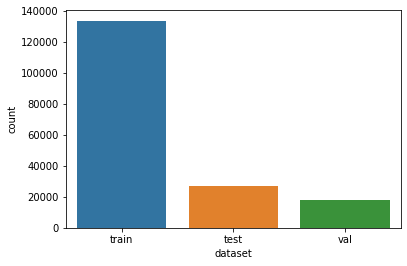

In [25]:
sns.countplot(x='dataset', data=concatenated)
plt.show()

Now, let's show the distribution of each class label in train, test and validation splits. As we can see classes are quite unbalanced but their distribution stays similar in different splits, which is what we expected.

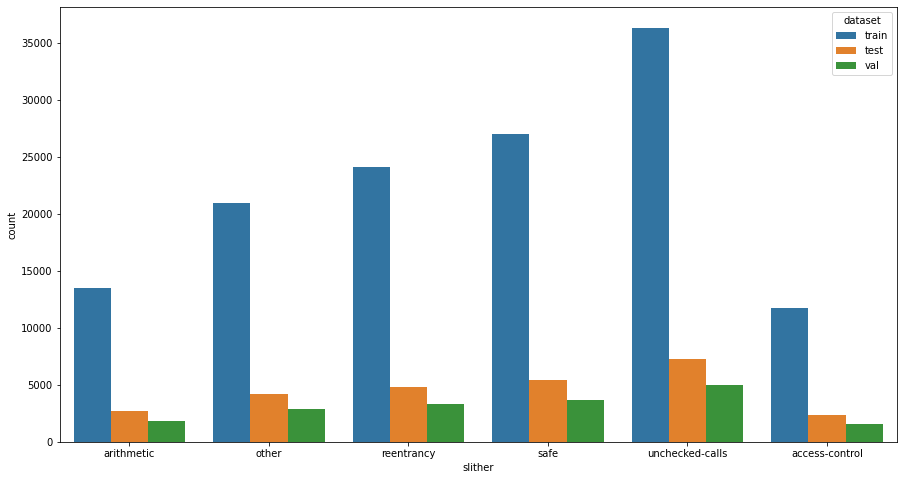

In [26]:
_, ax = plt.subplots(figsize=(15, 8))
sns.countplot(x='slither', data=concatenated, hue='dataset', ax=ax)

plt.show()

Next, we can drop the column containing the label (slither), as we do not need it anymore for the remaining analysis. We can also remove duplicate rows which we introduced previosuly using the pandas function .explode() to flatten the list of labels of our elements. We use this new dataframe to generate our histplots.

In [27]:
concatenated = concatenated.drop('slither', axis='columns')
concatenated = concatenated[~concatenated['address'].duplicated(keep='first')].reset_index()

Here we show the histogram related to the lenght (in words) of the source code files once the comment were removed. As we can see, for all the three splits the majority of the files have a lenght which is around 1000: there is however a small percentage of files for which the lenght arrives to almost 30000 words. A quick look at the source code of these long contracts shows that this is mostly due to the developers including also library code (i.e.: OpenZepplein) in the codebase published with their contract. 

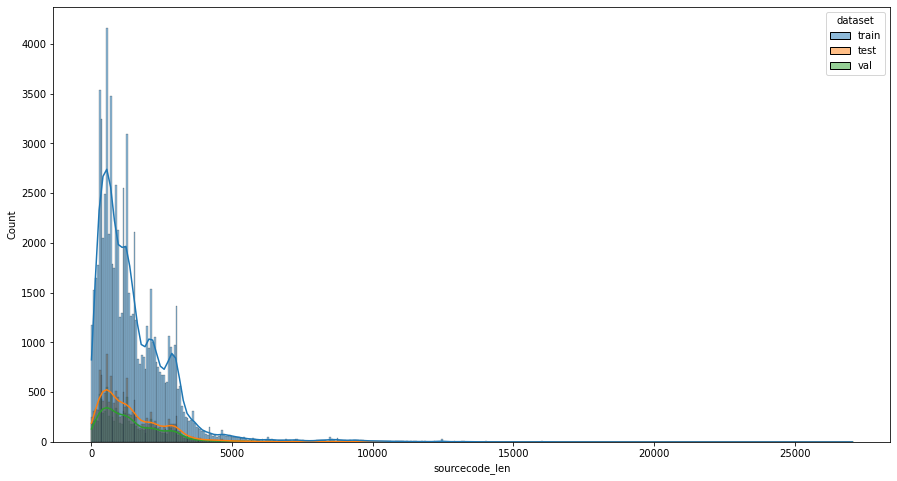

In [28]:
_, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=concatenated, x="sourcecode_len", kde=True, hue='dataset', ax=ax)
plt.show()

Here we show instead how the bytecodes do not necessarely have a peak lenght value, even if the majority of the still seem to be around 1000/2000 opcodes long.

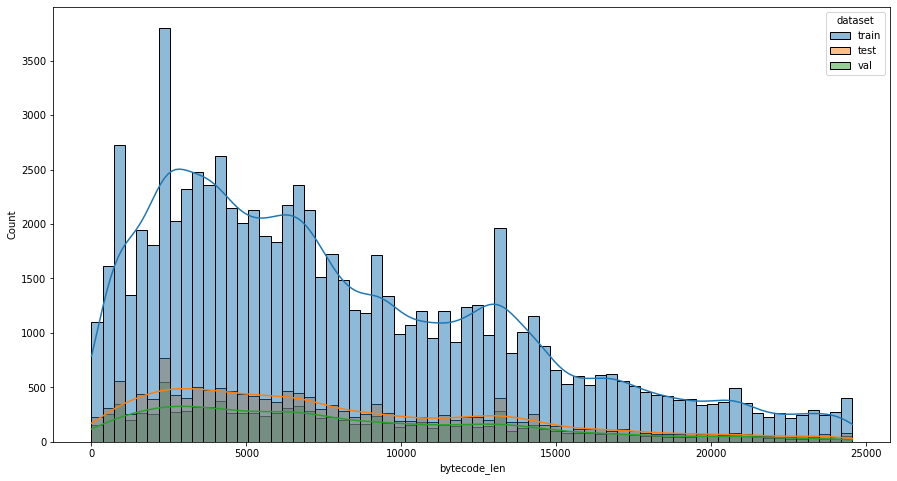

In [29]:
_, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=concatenated, x="bytecode_len", kde=True, hue='dataset', ax=ax)
plt.show()

Finally, now we show that the percentage of elements for which the bytecode was not available is negligible for all splits.

In [30]:
empty_bytecodes = concatenated[concatenated['bytecode_len'] == 0]['dataset'].value_counts()
empty_bytecodes

train    227
test      51
val       30
Name: dataset, dtype: int64

In [31]:
empty_bytecodes / concatenated['dataset'].value_counts()

train    0.002850
test     0.003193
val      0.002762
Name: dataset, dtype: float64